# New York City Construction Timeline Analysis

## Introduction

### Overview

Before a new building can begin construction it has to go through a long professional vetting process. The Department of Buildings (DOB) is the principal governmental organization responsible for overseeing the inspections and paperwork required for breaking ground.

The exact process, for the building manager involved, is summarized by [this handy chart](http://www1.nyc.gov/site/buildings/homeowner/dob-forms-applications.page). Here are the steps:

1. The applicant prefiles the application. Prefiling saves time, but not all applicants invoke it.
2. The applicant submits a work plan.
3. The plan is either professionally certified (a so-called "pro cert" or "self cert") or reviewed by the DOB.
4. The plan is approved or denied by the DOB.
5. Once a plan is approved, the applicant requests a work permit.
6. DOB issues a work permit.
7. Construction begins.

### Construction Job Application Process

Before a construction permit can be issued, Department of Buildings must receive, review, and approve a large number of support documents. The most important of these is the job plan, which contains the actual architectural schematic for the building to be constructed. Job plans may go through several iterations, resulting in the paper trail for the building.

### Construction Permit Process

Once a job plan has been submitted and all of the necessary support documents for the job are in order, the lot owners can file for and receive a construction permit from the Department of Buildings. Once this permit is issued, work can begin immediately.

### Certificate of Occupancy Process

The last step of new building construction is obtaining a certificate of occupancy ("C of O" for short). This document affirms that the building in question has been deemed to conform to the building code and is safe to occupy. 

A C of O is required for a building to be legally occupiable. DOB verifies with other coordinating agencies that all other outstanding requirements for the building have been satisfied before issuing the permit. Thus obtaining a C of O is the last step of the process in opening and occupying a building.

Most C of Os are permanent documents, however it is also possible to obtain an (expediated?) temporary document. Temporary C of Os have an expiration date, by which time a permanent document ought to have been granted. For our purposes we will treat them as equivalent documents.

### Measurement

The question of interest here is the amount of time that a building in New York City takes to go from filing its first job application to being issued its first certificate of occupancy. This process can be broken down into two stages. First, the time it takes to go from application to first permit; second, the time it takes to go from first permit to first certificate.

### Datasets

The datasets used here are `permit_occupancy_join_sample.csv` and `application_permit_join_sample.csv`, generated by the `Permit-to-Occupancy Processing.ipynb` and `Application-to-Permit Processing.ipynb` notebooks which are prior to this one.

### Workflow

I first consider the permit-to-occupancy and application-to-permit timelines seperately. These analyeses are linked together at the end of this notebook.

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import arrow
%matplotlib inline
pd.set_option("max_columns", 500)

## Permit-to-Occupancy Analysis

### Discussion

The sample of permit dates that we took consists of all borough-block-lots which recieved a construction permit in between April 25, 2013, when the open data record officially starts, and January 1, 2015, where our certificate of occupancy accessor algorithm ended its run. This means that every building has had at least 550 days in which to complete construction.

For times greater than 550 days we have partial data. Because the open data trail ends at our starting point any further data that we might recover from running the algorithm further forward in time would be of decreasing utility and increasing incompleteness, because those buildings will have less and less time in which to complete before they no longer show up in our dataset.

Amongst the negative results we also have no way of distinguishing between cases in which a construction permit was filed for but the idea was eventually dropped, and cases where the construction permit was filed for and there has been progress of one form or another but the building still remains to be completed.

This type of problem is known as a [survival analysis problem with censoring](http://stats.stackexchange.com/questions/222357/a-time-series-analysis-problem).


### Key Variables

The key variables of interest are:

* `Issuance Date` &mdash; The date that the first construction permit was issued.
* `Certificate Date` &mdash; The date that the first certificate of occupancy was issued.
* `Build Time` &mdash; The time between the first building permit and the first certificate of occupancy.

### Loading the Data

Because we saved to `CSV` format all of the date variables need to be reloaded into `numpy` data forms.

First we convert dates. We need two date fields, `Issuance Date` (the date when the lot got its first new building permit, of format e.g. `06/21/2013 12:00:00 AM`) and `Certificate Date` (the date when the lot got its first certificate of occupancy, of format e.g. `06-21-2013`). Unfortunately I erronously encoded one set of dates in one format and the other set of dates in another, so each must be converted seperately in a slightly different way. In both cases we get back `np.datetime64` objects.

Then we will re-encode the time deltas, stored as `N Days` strings in the `csv`, back into `np.timedelta64` objects.

Lastly we filter out of a few enonous negatives.

In [4]:
p_o_data = pd.read_csv("permit_occupancy_join_sample.csv", index_col=0)

In [6]:
p_o_data.head(1)

,Unnamed: 0.1,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year,Certificate Date,Build Time
0,26416,BRONX,2818049.0,92,WEST TREMONT AVE,220177350.0,1.0,NB,NaN,2867.0,125.0,205,10453,2.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,2013-06-21,06/21/2013 12:00:00 AM,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038.0,2.128637e+09,06/22/2013 12:00:00 AM,2013,2015-11-02,864 days 00:00:00.000000000


In [7]:
def convert_issuance_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date.split(" ")[0], 'MM/DD/YYYY').datetime)
    
def convert_certificate_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [8]:
p_o_data['Issuance Date'] = [convert_issuance_time(date) for date in p_o_data['Issuance Date']]
p_o_data['Certificate Date'] = [convert_certificate_time(date) for date in p_o_data['Certificate Date']]

In [9]:
def convert_time_delta(delta):
    if isinstance(delta, float):
        return None
    else:
        return np.timedelta64(delta.split(" ")[0], 'D')

In [11]:
for col in ['Build Time']:
    p_o_data[col] = [convert_time_delta(delta) for delta in p_o_data[col]]

In [26]:
p_o_data = p_o_data.drop("Unnamed: 0.1", axis='columns')

In [12]:
p_o_data = p_o_data[((p_o_data['Build Time'].isnull()) | (p_o_data['Build Time'] > np.timedelta64(0, "D")))]

### Naive Histogram

A histogram is not useful as a model, given the censoring that we are working around, but it does give us some idea of the shape of the data.

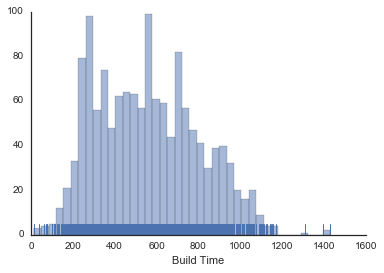

In [15]:
sns.set_style('white')
sns.distplot(p_o_data[p_o_data['Build Time'].notnull()]['Build Time'].map(lambda x: x.days),
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

This chart shows large singular spikes (hypothesized but unconfirmed to be building projects with a large number of units approved all at once) driving unexpectedly large construction numbers in certain months.

### Kaplan–Meier Model

The [Kaplan-Meier model](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) is a non-parametric estimator of the survival function for censored data (it's essentially what I tried but failed to implement in this notebook's earlier iteration).

I use the [`lifelines`](http://lifelines.readthedocs.io/en/latest/Quickstart.html) library for this.

C:\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:273: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  end_times_ = to_datetime(end_times, dayfirst=dayfirst, coerce=True)


(0, 1)

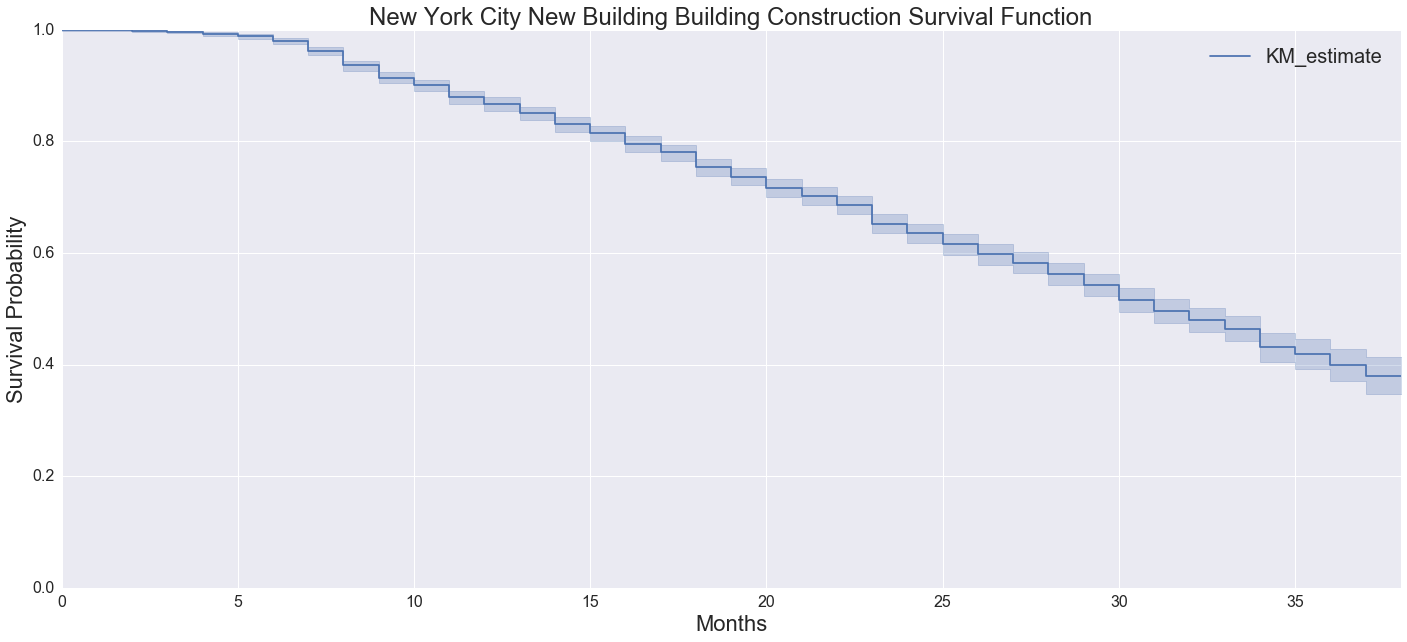

In [131]:
import lifelines
from lifelines.utils import datetimes_to_durations

T, C = datetimes_to_durations(p_o_data['Issuance Date'], p_o_data['Certificate Date'], freq='M')

p_o_kmf = lifelines.KaplanMeierFitter()
p_o_kmf.fit(T, event_observed=C)

sns.set(font_scale=2)
ax = p_o_kmf.plot(figsize=(24, 10), title='New York City New Building Building Construction Survival Function', fontsize=16)
ax.set_xlabel('Months')
ax.set_ylabel('Survival Probability')
ax.set_ylim([0, 1])

### Inverse Kaplan-Meier Model

This is the probability of a building not being built (surviving), we need to invert this to get the probability that it *is* built.

(0, 1)

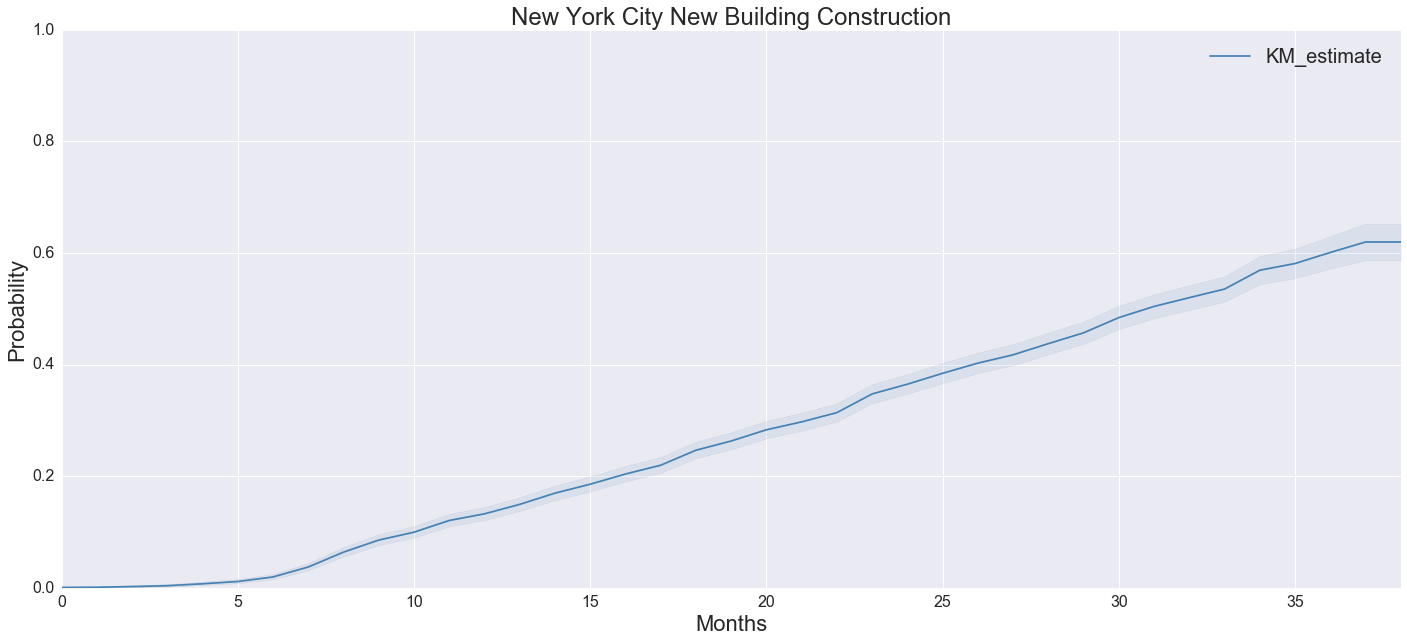

In [152]:
ax = (1 - p_o_kmf.survival_function_).plot(figsize=(24, 10),
                                           title='New York City New Building Construction',
                                           fontsize=16,
                                           color='steelblue')
ax.fill_between(range(0, len(p_o_kmf.survival_function_)),
                1 - p_o_kmf.confidence_interval_['KM_estimate_lower_0.95'],
                1 - p_o_kmf.confidence_interval_['KM_estimate_upper_0.95'],
                facecolor='steelblue',
                alpha=0.1
               )
ax.set_xlabel('Months')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])

### Analysis

After an initial lag time, lasting about the first half-a-year or so, the construction completion rate picks up and stays on in a linear fashion.

This is a very surprising result; coming into this project I had assumed that some average could be determined, and that new building construction completion rates are at least psuedo-normal. But they are instead time-constant!

The average value is not a meaningful statistic at all. The total percentage of buildings complete is unknown, but all of the percentiles out to ~60% completion and out 37 months are known.

Forecasting ability for individual records is yet to be determined, and I will attempt it, but I am moderately skeptical.

With more data&mdash;perhaps another year or so of it&mdash;we could get a better idea of where the curve peters out, and from there, of the total construction percentage.

## Application-to-Permit Analysis

### Discussion

The challenge is again the same: how do we account for the limitation on the time frame of our data? In this case I took all of the permit data between July 2016 and the beginning of 2015, and merged the job data onto that. Since the job data goes back to March 2013, this means that every permit had the opportunity for a year and a half of application acrrual ahead of getting an actual permit.

### Key Variables

The key variables of interest are:

* `Application Date` &mdash; The date that the first non pre-permit application was filed.
* `Issuance Date` &mdash; The date that the first construction permit was issued.
* `Application Time` &mdash; The amount of time that was spent between first application and first permit.

### Loading the Data

Again we first have to fix inputs.

In [104]:
a_p_data = pd.read_csv("application_permit_join_sample.csv", index_col=0)

In [106]:
def convert_issuance_and_application_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [107]:
a_p_data['Issuance Date'] = [convert_issuance_and_application_time(date) for date in a_p_data['Issuance Date']]

In [108]:
a_p_data['Application Date'] = [convert_issuance_and_application_time(date) for date in  a_p_data['Application Date']]

In [109]:
def convert_time_delta(delta):
    if isinstance(delta, float):
        return None
    else:
        return np.timedelta64(delta.split(" ")[0], 'D')

In [111]:
for col in ['Application Time']:
    a_p_data[col] = [convert_time_delta(delta) for delta in a_p_data[col]]

### Naive Histogram

Same caveats.

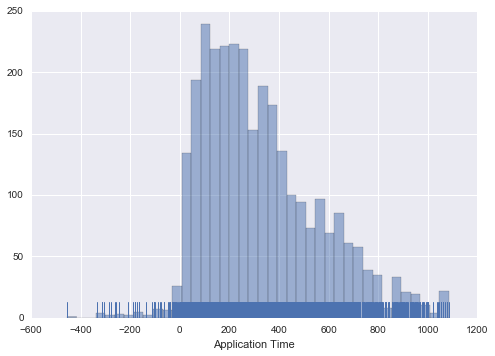

In [114]:
sns.set_style('white')
sns.set(font_scale=1)
sns.distplot(a_p_data[a_p_data['Application Time'].notnull()]['Application Time'].map(lambda x: x.days),
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

This histogram hints at the application data having a more definite and less noisy structure than the occupancy data.

### Kapan-Meier Model

An additional detail of implementing the model for this data: issuance data is complete, application data is not. This is the inverse of the expectation the model makes.

To fix this I inverted the `T`, `C` arrays manually. This required being a little clever, as its non-obvious what the relationship between `T` and `C` is in this case. But it is this: if both observations are present, `C[i]=True` and `T[i]=-timedelta`; if `C[i]=False` then `T[i]=observed_timedelta`. So just need to throw `np.abs()` at it!

It's important to note that our dataset contains the first **observed** application document. There are approximately 22 months of data for which the observations are complete, and this data we can trust. However, any data beyond 22 months may consist of records which were actually the second or third document in the sequenece of submissions, but which are nevertheless reported as the first by our algorithm, simply because the dataset cannot look back far enough to see the prior submissions.

The safest way to deal with this is to simply limit ourselves to the first 22 months.

In [117]:
a_p_data.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Application Date,Application Time
283979,BRONX,2116964,223,WEST 262ND STREET,220070946.0,1.0,NB,NaN,5888.0,165.0,208,10471.0,1.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,01/02/2015,2015-01-02,04/11/2015,01/02/2015,RICHARD,GALAIDA,KEY CONSTRUCTION ASSOC IN,8.603502e+09,GENERAL CONTRACTOR,0600957,,,,,,,MARIUSZ LUCZAJ,KEY CONSTRUCTION ASSOCIAT,INDIVIDUAL,NaN,NA,SCOTT,GALAIDA,11,SHERWOOD HILL ROAD,SEHRMAN,CT,6784.0,8.603502e+09,01/03/2015 12:00:00 AM,NaT,NaT


C:\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:273: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  end_times_ = to_datetime(end_times, dayfirst=dayfirst, coerce=True)
C:\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:280: UserWarning: Warning: some values of start_times are after end_times
  warnings.warn("Warning: some values of start_times are after end_times")


(0, 22)

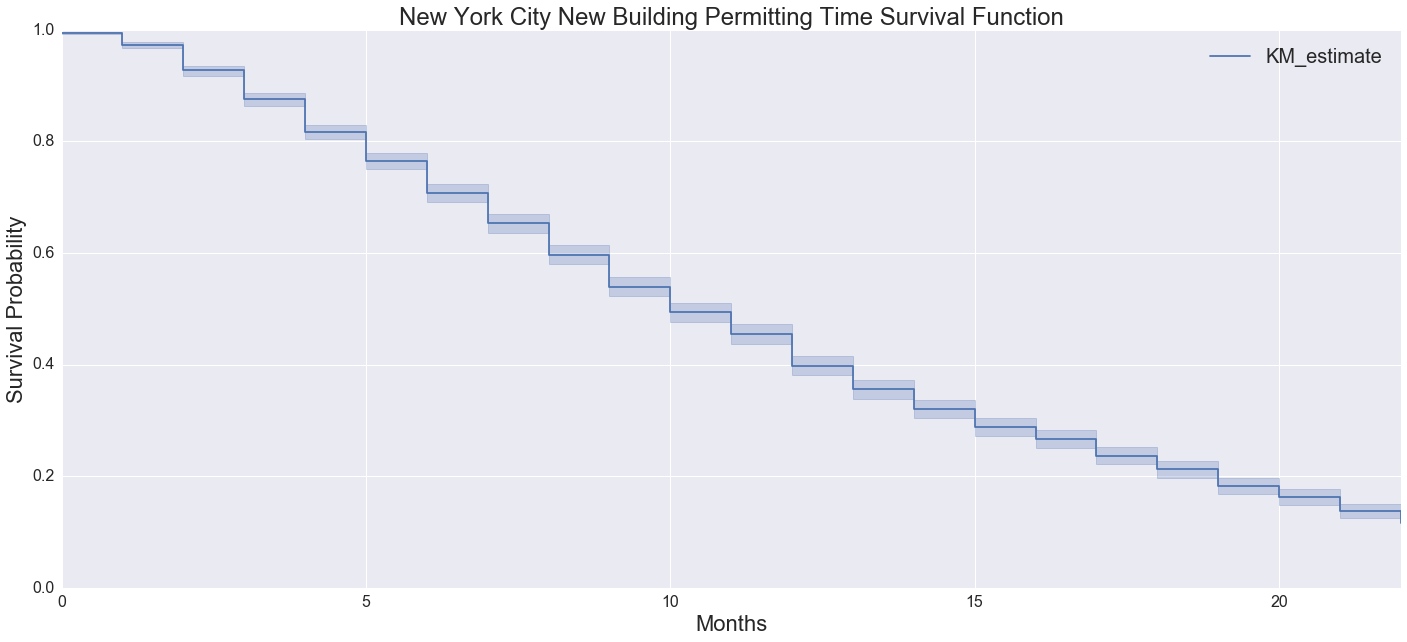

In [129]:
import lifelines
from lifelines.utils import datetimes_to_durations

T, C = datetimes_to_durations(a_p_data['Issuance Date'], a_p_data['Application Date'], freq='M')
T = np.abs(T)

a_p_kmf = lifelines.KaplanMeierFitter()
a_p_kmf.fit(T, event_observed=C)

sns.set(font_scale=2)
ax = a_p_kmf.plot(figsize=(24, 10), title='New York City New Building Permitting Time Survival Function', fontsize=16)
ax.set_xlabel('Months')
ax.set_ylabel('Survival Probability')
ax.set_ylim([0, 1])
ax.set_xlim([0, 22])

(0, 22)

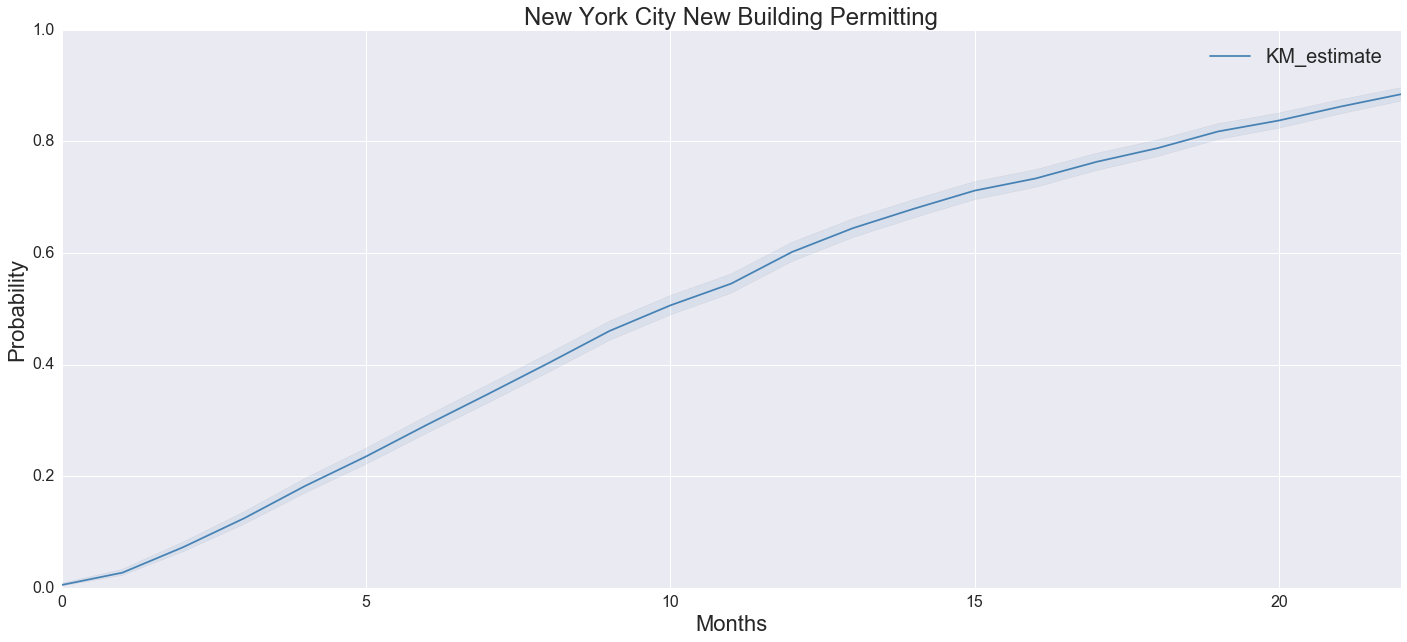

In [154]:
ax = (1 - a_p_kmf.survival_function_).plot(figsize=(24, 10),
                                           title='New York City New Building Permitting',
                                           fontsize=16,
                                           color='steelblue')
ax.fill_between(range(0, len(a_p_kmf.survival_function_)),
                1 - a_p_kmf.confidence_interval_['KM_estimate_lower_0.95'],
                1 - a_p_kmf.confidence_interval_['KM_estimate_upper_0.95'],
                facecolor='steelblue',
                alpha=0.1
               )
ax.set_xlabel('Months')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])
ax.set_xlim([0, 22])

AttributeError: 'Figure' object has no attribute 'set_ylim'

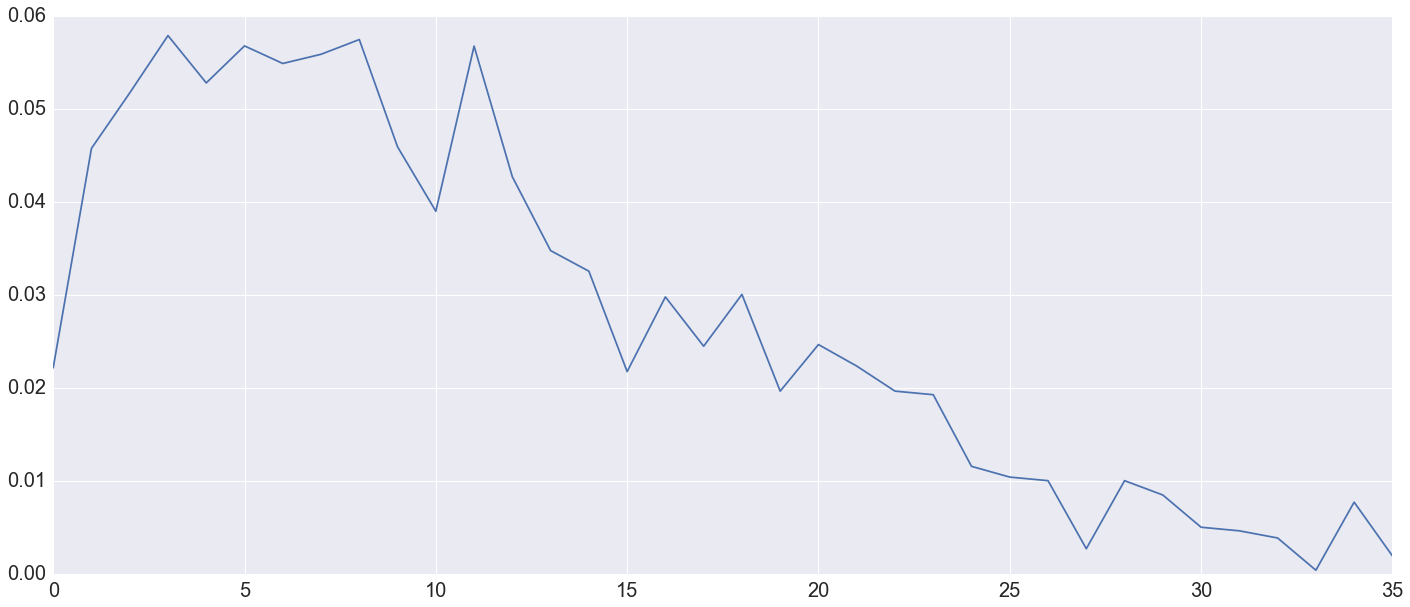

In [191]:
a_p_cdf = (1 - a_p_kmf.survival_function_)
a_p_pdf = a_p_cdf[1:].values - a_p_cdf.values[:len(a_p_cdf) - 1]
fig = plt.figure(figsize=(24, 10))
ax = plt.plot(a_p_pdf)
fig.set_ylim([0, 1])
fig.set_xlim([0, 22])

In [169]:
a_p_cdf[1:].values

array([[ 0.02714905],
       [ 0.07289158],
       [ 0.1245992 ],
       [ 0.1824719 ],
       [ 0.23525525],
       [ 0.29201852],
       [ 0.34689103],
       [ 0.40275323],
       [ 0.46019932],
       [ 0.50610517],
       [ 0.54508817],
       [ 0.60182625],
       [ 0.64451212],
       [ 0.67926166],
       [ 0.71180034],
       [ 0.7335443 ],
       [ 0.76331589],
       [ 0.78778727],
       [ 0.81782827],
       [ 0.83747046],
       [ 0.86211949],
       [ 0.88445768],
       [ 0.90409987],
       [ 0.92335693],
       [ 0.93491116],
       [ 0.94530997],
       [ 0.95532363],
       [ 0.95801962],
       [ 0.96803329],
       [ 0.97650639],
       [ 0.98151323],
       [ 0.98613492],
       [ 0.98998633],
       [ 0.99037147],
       [ 0.99807429],
       [ 1.        ]])

In [168]:
a_p_pdf = a_p_cdf[1:]

,KM_estimate
timeline,
0.0,0.004999
1.0,0.027149
2.0,0.072892
3.0,0.124599
4.0,0.182472
5.0,0.235255
6.0,0.292019
7.0,0.346891
8.0,0.402753


In [164]:
a_p_kmf.survival_function_.values[::-1]

array([[ 0.        ],
       [ 0.00192571],
       [ 0.00962853],
       [ 0.01001367],
       [ 0.01386508],
       [ 0.01848677],
       [ 0.02349361],
       [ 0.03196671],
       [ 0.04198038],
       [ 0.04467637],
       [ 0.05469003],
       [ 0.06508884],
       [ 0.07664307],
       [ 0.09590013],
       [ 0.11554232],
       [ 0.13788051],
       [ 0.16252954],
       [ 0.18217173],
       [ 0.21221273],
       [ 0.23668411],
       [ 0.2664557 ],
       [ 0.28819966],
       [ 0.32073834],
       [ 0.35548788],
       [ 0.39817375],
       [ 0.45491183],
       [ 0.49389483],
       [ 0.53980068],
       [ 0.59724677],
       [ 0.65310897],
       [ 0.70798148],
       [ 0.76474475],
       [ 0.8175281 ],
       [ 0.8754008 ],
       [ 0.92710842],
       [ 0.97285095],
       [ 0.99500147]])

In [165]:
(1 - a_p_kmf.survival_function_)[1:]

,KM_estimate
timeline,
1.0,0.027149
2.0,0.072892
3.0,0.124599
4.0,0.182472
5.0,0.235255
6.0,0.292019
7.0,0.346891
8.0,0.402753
9.0,0.460199


### Analysis

This data shows somewhat more

Just as with the permit-occupancy data, the model points to highly linear 

This is a very surprising result; coming into this project I had assumed that some average could be determined, and that new building construction completion rates are at least psuedo-normal. But they are instead time-constant!

The average value is not a meaningful statistic at all. The total percentage of buildings complete is unknown, but all of the percentiles out to ~60% completion and out 37 months are known.

Forecasting ability for individual records is yet to be determined, and I will attempt it, but I am moderately skeptical.

With more data&mdash;perhaps another year or so of it&mdash;we could get a better idea of where the curve peters out, and from there, of the total construction percentage.

## End-to-End &mdash; Application-Permit-Occupancy Convolution

### Discussion

We have arrived at a reasonably good model of new building permitting time and a reasonably good model of new building certificate of occupancy time. Can these two things be consolidated into an end-to-end?

We cannot do this directly. Our two datasets concern permits from completely different time periods; taking permits from the same time period would result in garbage on both sides due to uncertaincy in time. This is because the sample of permits that we took was from May 2013 through the end of 2014. The permit is the last step of the application document trail, and our application data goes back the same amount, to May 2013 ([see here](https://github.com/ResidentMario/nyc-construction-timeline/blob/cdb44fe7315bb761226a427b4ab0f1612a4b54e9/Application-to-Permit%20Processing.ipynb); notebook code no longer current).

If the two times are independently distributed, we can simply combine them through [probabilistic convolution](https://en.wikipedia.org/wiki/Convolution_of_probability_distributions). But these two times are *not* independently distributed at all!

**TODO**: Run the classification models to see which factors are important for either dataset; this should give us a sense of how safe we are in doing a naive merge, and if we are not safe, at least give us some spitball multiplier we can maybe use.